<a href="https://colab.research.google.com/github/arjun372/NE795-SciML/blob/main/Homework%201/HW1_Problem6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 6 - Deep Neural Network with Tensorflow-Keras

For this problem, we will utilize the environment provided by Google Colab. Although the prompt specifies the use of Keras, we will use Tensorflow v2.0 with Keras support. Runtime support includes Nvidia A100 and Google TPU. We are using the A100 here.

The following steps specify our development process:

## Install the runtime dependencies
This include `tensorflow==2.13.0`, `numpy==1.23.5`, and `scikit-learn==1.2.2`.

In [ ]:
## Install the environment

!pip install tensorflow==2.13.0 numpy==1.23.5 scikit-learn==1.2.2

In [ ]:
## Import necessary libraries
import os
import tensorflow as tf
print("tensorflow: ", tf.__version__)
import sklearn
from tensorflow.keras.datasets import mnist
from sklearn.metrics import classification_report
print("sklearn: ", sklearn.__version__)
import numpy as np
print("numpy: ", sklearn.__version__)

tensorflow:  2.13.0
sklearn:  1.2.2
numpy:  1.2.2


## 1. Data loading

We perform this operation in two steps:
 * Load the MNIST dataset
 * Normalize the images

The MNIST dataset is divided into two parts: 60,000 data points of training data (x_train for the images and y_train for the labels), and 10,000 points of test data (x_test for the images and y_test for the labels).

The images are grayscale and the pixel values range from 0 to 255. Dividing the pixel values by 255 scales the data to range between 0 and 1.

Finally, the data is one-hot encoded.

In [ ]:
## 1. Data loading

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


## 2. Handwritten digits visualization

We display the images using `matplotlib.pyplot`. `axes.ravel()` flattens the 2D array of axes into a 1D array, so that they can be easily looped over. This is necessary because `plt.subplots` returns a 2D array of axes when it's called with two arguments.

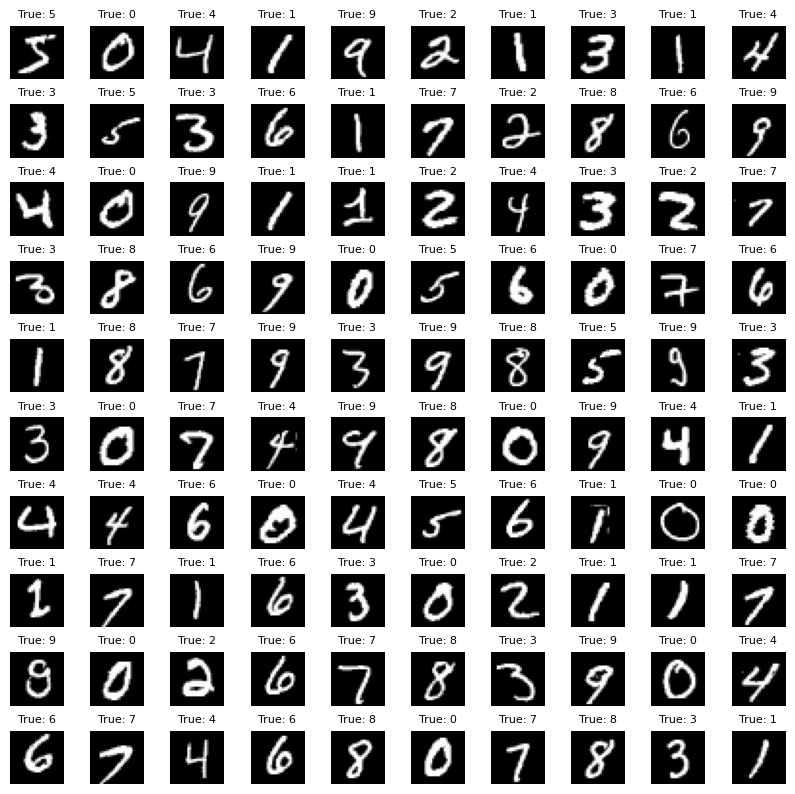

In [ ]:
## 2. Handwritten digits visualization

import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.ravel()

for i in np.arange(0, 100):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title("True: %s" % y_train[i], fontsize=8)
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## 3. Build and train a simple DNN

Next, we define our methods in section 3.1 and perform the analysis in sections 3.2 and 3.3

In [ ]:
## 3. Build and train a simple DNN


### 3.1 Define the methods

"""
We like using the GPU over the TPU for these small problems since the TPU
shines when the throughput requirement is large. For these smaller models,
the TPU is 3x-10x slower than the CPU.
"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from typing import List
from typing import Optional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import Regularizer

def build(neurons: int = 10, hidden_layers: int = 1, activation: str = 'relu',
          regularizer: Optional[Regularizer] = None,
          dropout_rate: Optional[float] = None,
          ) -> Sequential:
  """
  Builds a Sequential model with specified parameters.

  Args:
      neurons (int, optional): The number of neurons in each hidden layer. Defaults to 10.
      hidden_layers (int, optional): The number of hidden layers in the model. Defaults to 1.
      activation (str, optional): The activation function to be used in the hidden layers. Defaults to 'relu'.

  Returns:
      Sequential: A Sequential model with the specified number of hidden layers and neurons, and the specified activation function.

  This function uses the Keras Sequential model API to build a model for classifying MNIST digits.
  The model is composed of a Flatten layer, followed by a specified number of Dense layers (hidden_layers)
  with a specified number of neurons (neurons) and a specified activation function (activation),
  and finally a Dense layer with 10 neurons and a softmax activation function for output.
  """
  layers: List = [Flatten(input_shape=(28, 28))]
  for layer in range(0, hidden_layers):
      layers.append(Dense(neurons, activation=activation, kernel_regularizer=regularizer))
  if dropout_rate is not None:
    layers.append(Dropout(rate=dropout_rate))
  layers.append(Dense(10, activation='softmax'))
  model = Sequential(layers)
  model.summary()
  return model


from typing import Union
from tensorflow.keras.models import Model
import numpy as np

def train(model: Model, x_train: np.ndarray = x_train, y_train: np.ndarray = y_train,
          epochs: int = 5, optimizer: str = 'adam', loss: str = 'sparse_categorical_crossentropy',
          validation_data=(x_test, y_test), callbacks = None) -> Model:
  """
  Trains a Keras model on the provided training data.

  Args:
      model (Model): The Keras model to be trained.
      x_train (np.ndarray): The training data.
      y_train (np.ndarray): The labels of the training data.
      epochs (int, optional): The number of epochs for training the model. Defaults to 5.
      optimizer (str, optional): The optimizer to be used for training the model. Defaults to 'adam'.
      loss (str, optional): The loss function to be used for training the model. Defaults to 'sparse_categorical_crossentropy'.

  Returns:
      Model: The trained Keras model.
  """
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=epochs, validation_data=validation_data, callbacks=callbacks)
  return model, history


from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model: Model, x_test: np.ndarray = x_test, y_test: np.ndarray = y_test):
  """
  Evaluate the performance of a model on the test dataset.

  This function will print the classification report and plot the confusion matrix.

  Args:
      model (Model): The trained model to be evaluated.
      x_test (np.ndarray): The test data.
      y_test (np.ndarray): The true labels for the test data.

  Returns:
      None
  """
  model.evaluate(x_test,  y_test, verbose=2)
  y_pred: np.ndarray = model.predict(x_test)
  y_pred: np.ndarray = np.argmax(y_pred, axis=1)
  report = classification_report(y_test, y_pred)
  cm: np.ndarray = confusion_matrix(y_test, y_pred)
  return report, cm

import seaborn as sns
from matplotlib import pyplot as plt

def subplot(confusion_matrix: Union[List[List[int]], List[List[float]]], title: str, ax: plt.Axes) -> None:
    """
    Create a subplot with a heatmap displaying a confusion matrix.

    Args:
        confusion_matrix (List[List[int]] or List[List[float]]): The confusion matrix to be displayed.
            Rows represent the ground truth, and columns represent predicted values.
        title (str): The title for the subplot.
        ax (plt.Axes): The Matplotlib Axes where the heatmap should be plotted.

    Returns:
        None
    """
    sns.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax)
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')
    ax.set_title(title)


def subplot_loss_history(history: dict, title: str, ax: plt.Axes) -> None:
    """
    Create a subplot to visualize loss history during training.

    Args:
        history (dict): A dictionary containing training history information, typically obtained from
            Keras' model.fit() method.
        title (str): The title for the subplot.
        ax (plt.Axes): The Matplotlib Axes where the loss history plot should be plotted.

    Returns:
        None
    """
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')



Found GPU at: /device:GPU:0


In [ ]:
### 3.2 Train the models once

model20 = train(build(neurons=20))
model50 = train(build(neurons=50))
model100 = train(build(neurons=100))

313/313 - 1s - loss: 0.1585 - accuracy: 0.9544 - 522ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 0.0957 - accuracy: 0.9695 - 587ms/epoch - 2ms/step
313/313 [==============================] - 0s 2ms/step
313/313 - 1s - loss: 0.0842 - accuracy: 0.9718 - 527ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.96      0.92      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.92      0.95      0.94       892
           6       0.95      0.97      0.96       958
           7       0.95      0.96      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.95      0.92      0.94      1009

    accuracy           

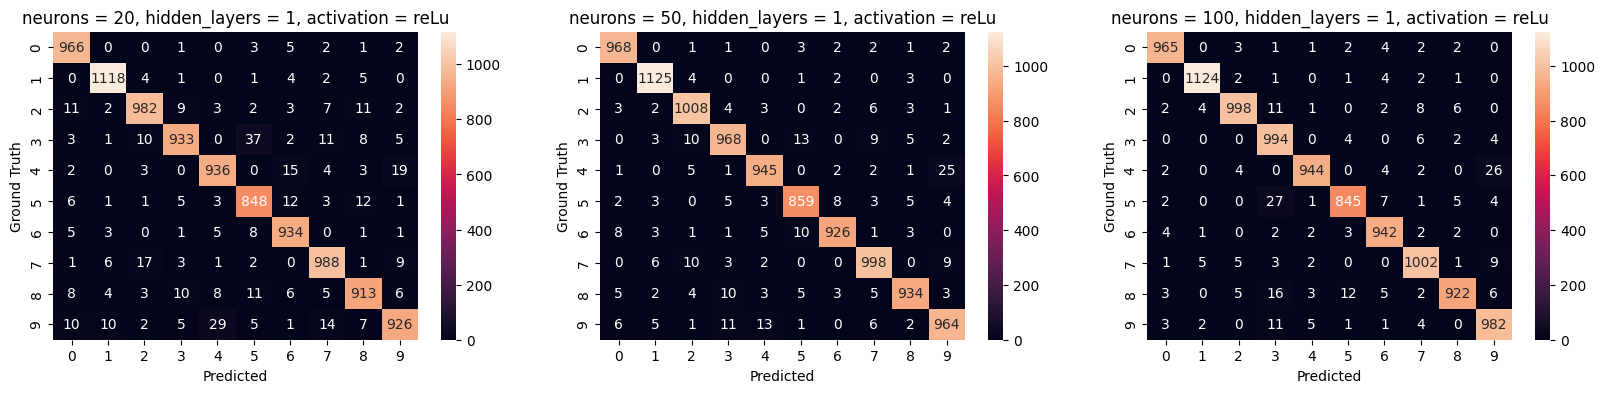

In [ ]:
### 3.2 Evaluate and compare the performance


report20, cm20 = evaluate(model20)
report50, cm50 = evaluate(model50)
report100, cm100 = evaluate(model100)

print(report20, report50, report100)

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
subplot(cm20, "neurons = 20, hidden_layers = 1, activation = reLu", ax[0])
subplot(cm50, "neurons = 50, hidden_layers = 1, activation = reLu", ax[1])
subplot(cm100, "neurons = 100, hidden_layers = 1, activation = reLu", ax[2])


### 3.2 Effect of hidden neuron count on model accuracy

From the results, we can see that as the number of hidden neurons increases, the precision, recall, and f1-score of the model on the test set generally increase. This suggests that a model with more hidden neurons has a higher capacity and can fit the training data better, thus achieving higher performance on the test set.

However, this doesn't mean that more neurons will always mean better performance. If the model has too many parameters, it may overfit the training data and perform poorly on unseen/test data. This is an example of the bias-variance tradeoff.

In our example, the model with 20 hidden neurons has slightly lower performance than the models with 50 and 100 hidden neurons. The models with 50 and 100 hidden neurons have similar performance, suggesting that increasing the number of hidden neurons beyond 50 doesn't lead to significant improvements in this case.

In terms of individual classes, the model's performance is relatively consistent across different classes, indicating that the model doesn't have a significant bias towards certain digits.

## 4. Activation and cost functions

### 4.1 Activation Functions in TensorFlow

#### 4.1.2 Supported Activation Functions Types

1. **ReLU (Rectified Linear Unit)** `relu`: The function returns 0 if it receives any negative input, but for any positive value `x` it returns that value back.

2. **Sigmoid** `sigmoid`: It's a function that maps the input values between 0 and 1, making it especially useful for models where we have to predict the probability as an output.

3. **Tanh (Hyperbolic Tangent)** `tanh`: The tanh function is very similar to the sigmoid function but it maps the input values between -1 and 1.

4. **Softmax** `softmax`: The softmax function is a more generalized logistic activation function which is used for multiclass classification.

5. **Softplus** `softplus`: Softplus is a smooth approximation to the ReLU function.

6. **Softsign** `softsign`: Softsign is a smooth approximation to the sign function.

7. **Selu (Scaled Exponential Linear Unit)** `selu`: The SELU activation function scales inputs by a predefined lambda to ensure a mean of 0 and standard deviation of 1.

8. **Elu (Exponential Linear Unit)** `elu`: The ELU activation function tends to converge cost to zero faster and produce more accurate results in general.

9. **Swish** `swish`: Swish is a self-gated activation function.

10. **Gelu (Gaussian Error Linear Unit)** `gelu`: Gelu is a smooth approximation to the ReLU function.

#### 4.1.3 Activation Function Comparisons

In our analysis, we will compare the performance of the following activation functions for a single hidden layer, with 100 hidden neurons:


*   softmax
*   tanh
*   relu
*   sigmoid

In [ ]:
#### 4.1.1 Evaluate and compare the performance for different activation functions
relu = model100
softplus = train(build(neurons=100, activation='softplus'))
tanh = train(build(neurons=100, activation='tanh'))
sigmoid = train(build(neurons=100, activation='sigmoid'))

313/313 - 1s - loss: 0.0870 - accuracy: 0.9738 - 528ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 0.0859 - accuracy: 0.9738 - 518ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 0.1045 - accuracy: 0.9686 - 554ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.93      0.98      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy           

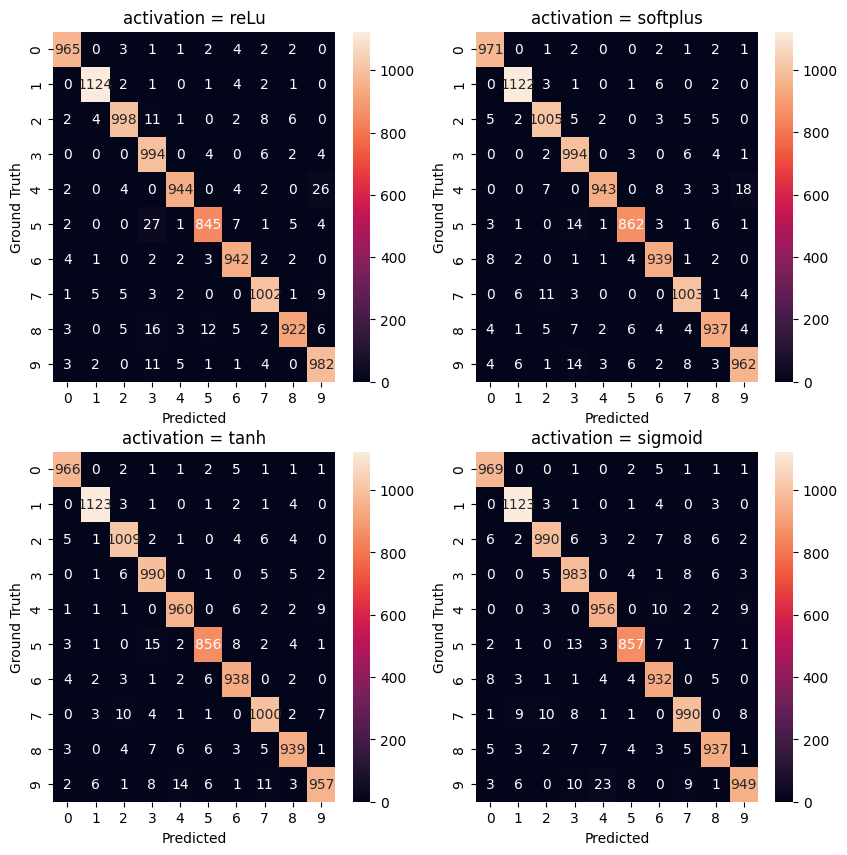

In [ ]:
#### 4.1.1 Evaluate and compare the performance

report_relu, cm_relu = report100, cm100
report_softplus, cm_softplus = evaluate(softplus)
report_tanh, cm_tanh = evaluate(tanh)
report_sigmoid, cm_sigmoid = evaluate(sigmoid)


print(report_relu, report_softplus, report_tanh, report_sigmoid)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
subplot(cm_relu, "activation = reLu", ax[0][0])
subplot(cm_softplus, "activation = softplus", ax[0][1])
subplot(cm_tanh, "activation = tanh", ax[1][0])
subplot(cm_sigmoid, "activation = sigmoid", ax[1][1])

#### 4.1.4 Discussion - Activation Function Comparision

From the results, we that all four activation functions (ReLU, Softplus, Tanh, and Sigmoid) have similar performance in terms of precision, recall, and F1-score. The overall accuracy for all four activation functions is 0.97. This suggests that for this particular problem, the choice of activation function does not significantly impact the model's performance.

However, there are slight differences in precision, recall, and F1-score for individual classes across different activation functions. For example, the ReLU activation function has a slightly lower precision and recall for class 3 compared to the other activation functions. Similarly, the sigmoid activation function has a slightly lower recall for class 9.

These differences could be due to the properties of the activation functions. ReLU is a piecewise linear function that will output the input directly if it is positive; otherwise, it will output zero softplus is a smooth approximation to the ReLU function. Tanh is similar to the sigmoid function but may sometimes function better because it is zero-centered. The sigmoid function maps the input values into the range between 0 and 1.

Ultimately, while the choice of activation function may not make a huge impact on the overall performance of a model, it can lead to slight differences in the performance for individual classes.

### 4.2 Loss Functions in TensorFlow for Classification Problems

In TensorFlow, there are several loss functions for classification problems:

1. **BinaryCrossentropy**: This cross-entropy loss can be used when there are only two label classes (assumed to be 0 and 1).

2. **CategoricalCrossentropy**: This cross-entropy loss function when there are two or more label classes in one-hot representation.

3. **SparseCategoricalCrossentropy**: Use this cross-entropy loss function when there are two or more label classes in integer notation.

4. **KLDivergence**: Computes Kullback-Leibler divergence loss between `y_true` and `y_pred`.

5. **Poisson**: Computes the Poisson loss between `y_true` and `y_pred`.

6. **MeanSquaredError**: Computes the mean of squares of errors between labels and predictions.

7. **MeanAbsoluteError**: Computes the mean of the absolute difference between labels and predictions.

8. **MeanSquaredLogarithmicError**: Computes the mean squared logarithmic error between `y_true` and `y_pred`.

9. **Hinge**: Computes the hinge loss between `y_true` and `y_pred`.

10. **SquaredHinge**: Computes the squared hinge loss between `y_true` and `y_pred`.

11. **CategoricalHinge**: Computes the categorical hinge loss between `y_true` and `y_pred`.

#### 4.2.1 Loss Function Comparisons

In our analysis, we will compare the following loss functions for a single hidden layer network, with 100 neurons with the `relu` activation function:

*   `sparse_categorical_crossentropy`
*   `categorical_hinge`
*   `mean_absolute_error`
*   `kullback_leibler_divergence`


In [ ]:
#### First, convert the outputs to one-hot-encoding so that they can work with the other loss functions!
from tensorflow.keras.utils import to_categorical

y_train_1hot = to_categorical(y_train, num_classes=10)
y_test_1hot = to_categorical(y_test, num_classes=10)

sparse_categorical_crossentropy = relu
categorical_hinge = train(model=build(neurons=100), y_train=y_train_1hot, loss='categorical_hinge')
mean_absolute_error = train(model=build(neurons=100), y_train=y_train_1hot, loss='mean_absolute_error')
kl_divergence = train(model=build(neurons=100), y_train=y_train_1hot, loss='kullback_leibler_divergence')

313/313 - 0s - loss: 0.1955 - accuracy: 0.0998 - 495ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 4.3630 - accuracy: 0.0984 - 525ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 107.5640 - accuracy: 0.0986 - 568ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.93      0.98      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy         

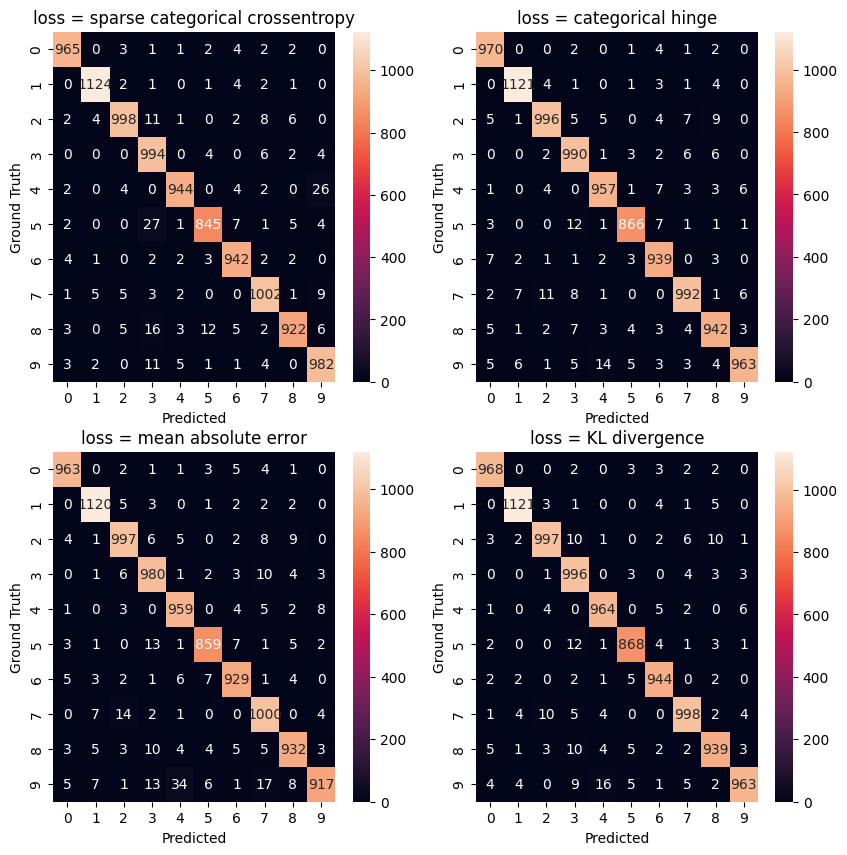

In [ ]:
#### 4.2.1 Loss Function Comparisons

report_scce, cm_scce = report_relu, cm_relu
report_ch, cm_ch = evaluate(categorical_hinge)
report_mae, cm_mae = evaluate(mean_absolute_error)
report_kld, cm_kld = evaluate(kl_divergence)


print(report_scce, report_ch, report_mae, report_kld)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
subplot(cm_scce, "loss = sparse categorical crossentropy", ax[0][0])
subplot(cm_ch, "loss = categorical hinge", ax[0][1])
subplot(cm_mae, "loss = mean absolute error", ax[1][0])
subplot(cm_kld, "loss = KL divergence", ax[1][1])


#### 4.2.2 Discussion - Loss Function Comparison

The loss function is a measure of how well the model is able to predict the expected outcome. A lower loss value means the model's predictions are close to the actual values, and thus the model performs better.

In order to use some loss functions, we had to one-hot encode the labels.

From the results, it can be seen that all four loss functions - `sparse_categorical_crossentropy`, `categorical_hinge`, `mean_absolute_error`, and `kullback_leibler_divergence` - have similar performance in terms of precision, recall, and f1-score. The accuracy, macro average, and weighted average are all around 0.97 or 0.98, indicating that the model performs well regardless of the loss function used.

However, there are slight differences. For instance, the model with the `kullback_leibler_divergence` loss function seems to perform slightly better than the others, with the highest accuracy and averages. This might be because this loss function is more suitable for the problem of multi-class classification, as it measures the distance between the predicted probabilities and the actual values.

On the other hand, the model with the `mean_absolute_error` loss function seems to have slightly lower performance for class 9, with a recall of 0.91 compared to 0.95-0.99 for the other loss functions. This might be because this loss function is less sensitive to outliers, which could be more common in class 9.

## 5. Hidden Layers

For this section, we will test the performance of the model with 1, 2, 4, 8 hidden layer, each with 100 neurons, with the `relu` activation function, and the `kld` loss function.

In [ ]:
## Hidden layer analysis
layers_1 = kl_divergence
layers_2 = train(model=build(neurons=100, hidden_layers=2), y_train=y_train_1hot, loss='kullback_leibler_divergence')
layers_4 = train(model=build(neurons=100, hidden_layers=4), y_train=y_train_1hot, loss='kullback_leibler_divergence')
layers_8 = train(model=build(neurons=100, hidden_layers=8), y_train=y_train_1hot, loss='kullback_leibler_divergence')

313/313 - 1s - loss: 113.0878 - accuracy: 0.0982 - 594ms/epoch - 2ms/step
313/313 [==============================] - 1s 1ms/step
313/313 - 1s - loss: 101.2801 - accuracy: 0.0979 - 654ms/epoch - 2ms/step
313/313 [==============================] - 1s 1ms/step
313/313 - 1s - loss: 99.5907 - accuracy: 0.0995 - 734ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.95      0.99      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.98      0.95      0.97      1009

    accuracy      

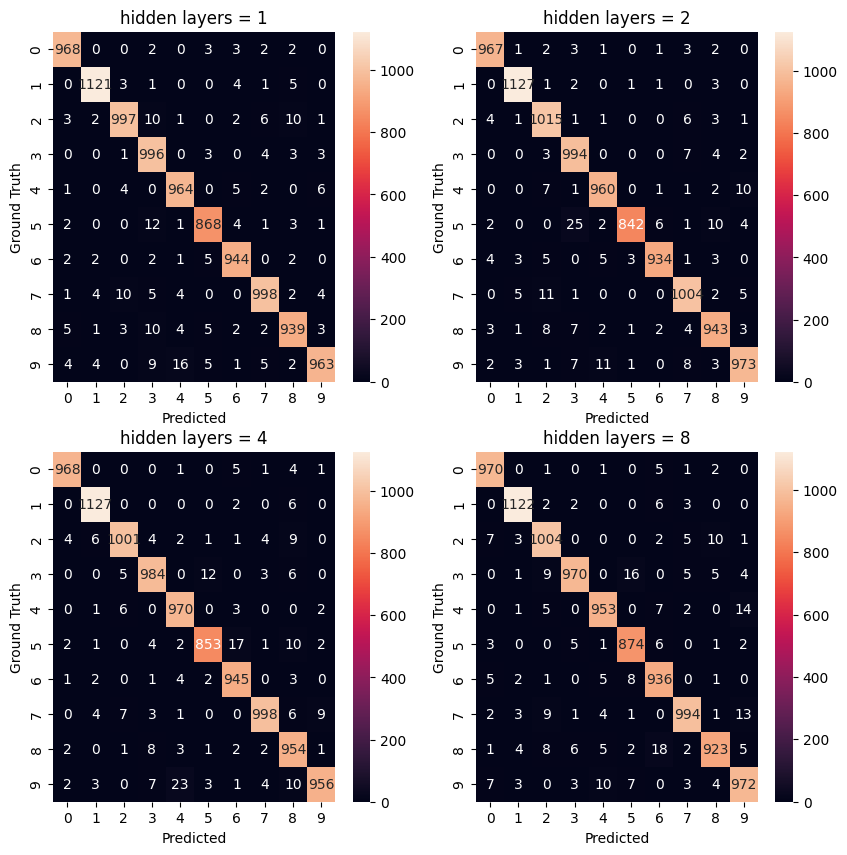

In [ ]:
### 5.1 Hidden Layer Comparison

report_1, cm_1 = report_kld, cm_kld
report_2, cm_2 = evaluate(layers_2)
report_4, cm_4 = evaluate(layers_4)
report_8, cm_8 = evaluate(layers_8)


print(report_1, report_2, report_4, report_8)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
subplot(cm_1, "hidden layers = 1", ax[0][0])
subplot(cm_2, "hidden layers = 2", ax[0][1])
subplot(cm_4, "hidden layers = 4", ax[1][0])
subplot(cm_8, "hidden layers = 8", ax[1][1])

## 5.1 Discussion - Hidden Layers

The results show that the model's performance remains relatively stable as the number of hidden layers increases from 1 to 4, with the overall accuracy staying at 0.98. However, when the number of hidden layers increases to 8, the overall accuracy slightly decreases to 0.97.

In theory, adding more hidden layers to a neural network  can help capture more complex patterns in the data, potentially improving the model's performance. However, this is not always the case in practice. As we can see from the results, the model's performance does not improve with the increase in the number of hidden layers. This could be due to several reasons:

* **Overfitting**: As the model becomes more complex (i.e., more hidden layers), it might start to overfit the training data, leading to a decrease in performance on the test data.

* **Vanishing/Exploding Gradients**: In DNNs, gradients can become too small (vanish) or too large (explode) during backpropagation, making the network hard to train. This could also lead to a decrease in performance.

## 6. Overfitting and Regularization

The following code and outputs demonstrate overfitting, along with optimizations that help reduce the effects of overfitting.

In [ ]:
## 6. Overfitting with regularization, droput, and early stopping

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

overfitted, history_overfitted = train(model=(build(neurons = 1024)), epochs=12)
early, early_history = train(model=build(neurons = 1024), epochs=12, callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
dropout, dropout_history = train(model=(build(neurons = 1024, dropout_rate=0.2)), epochs=12)
l1_regularized, l1_regularized_history = train(model=(build(neurons = 1024, regularizer=l1(0.02))), epochs=12)
l2_regularized, l2_regularized_history = train(model=(build(neurons = 1024, regularizer=l2(0.02))), epochs=12)
all, all_history = train(model=(build(neurons = 1024, dropout_rate=0.2, regularizer=l2(0.02))), epochs=12, callbacks=[early_stopping])


In [ ]:
all, all_history = train(model=(build(neurons = 1024, dropout_rate=0.2, regularizer=l2(0.02))), epochs=12, callbacks=[early_stopping])

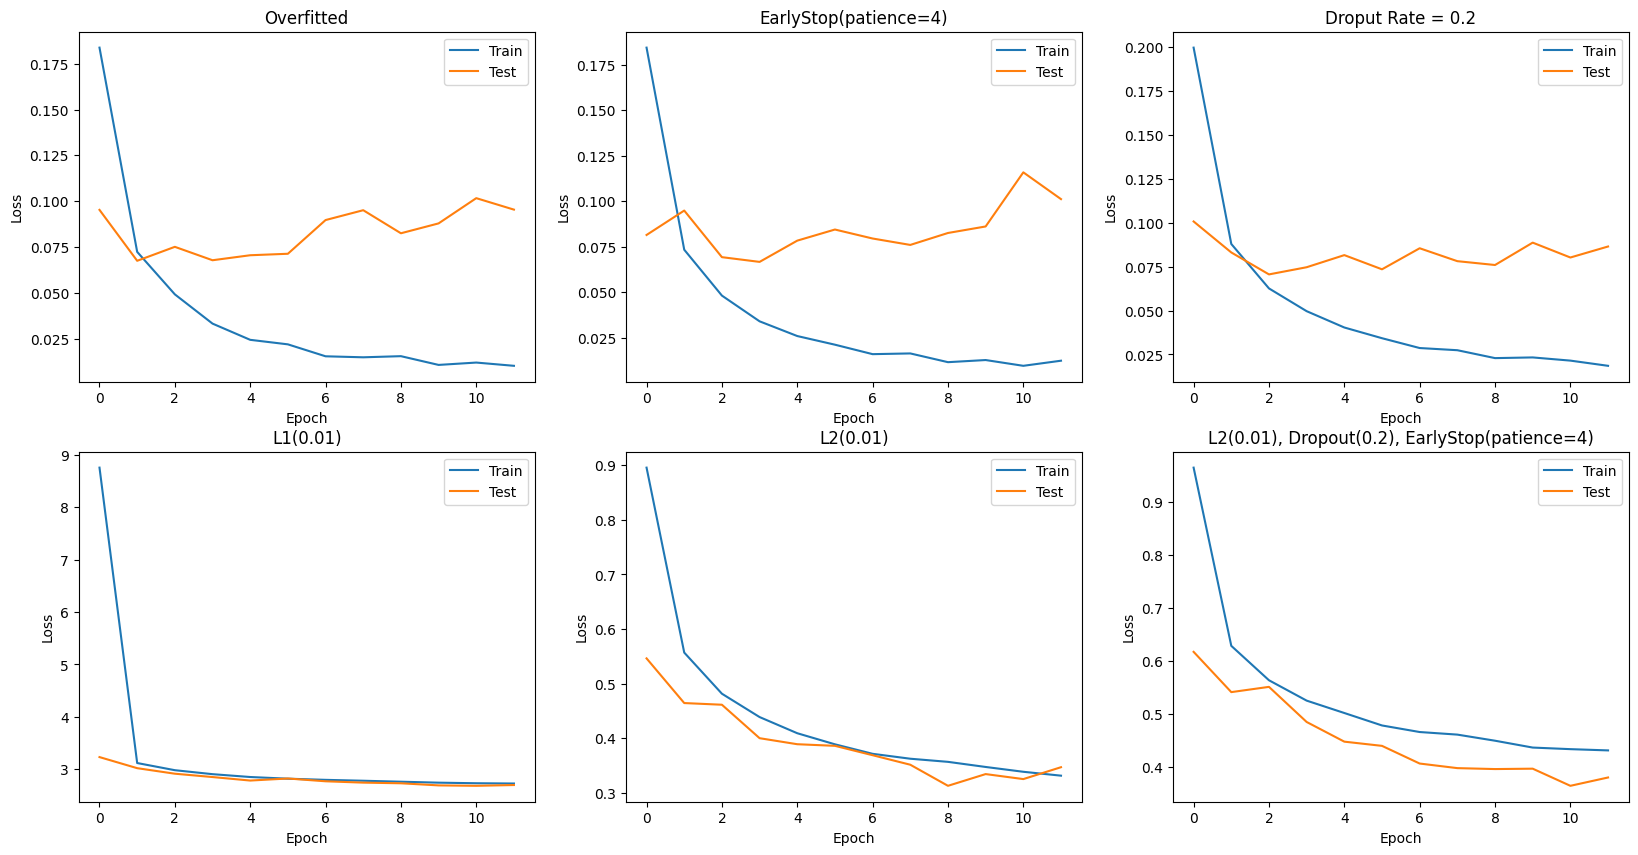

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

subplot_loss_history(history_overfitted, title="Overfitted", ax=ax[0][0])
subplot_loss_history(early_history, title="EarlyStop(patience=4)", ax=ax[0][1])
subplot_loss_history(dropout_history, title="Droput Rate = 0.2", ax=ax[0][2])
subplot_loss_history(l1_regularized_history, title="L1(0.01)", ax=ax[1][0])
subplot_loss_history(l2_regularized_history, title="L2(0.01)", ax=ax[1][1])
subplot_loss_history(all_history, title="L2(0.01), Dropout(0.2), EarlyStop(patience=4)", ax=ax[1][2])


## 7. Hyperparameter Tuning

For our case, we will consider mini-batchsze, learning rate, regularization and the dropout rate. We will use the `keras tuner` library.

In [ ]:
!pip install keras-tuner

In [ ]:
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.regularizers import l2

def build_model(hp):
    """
    Build and train a model with a variable number of neurons, dropout, regularization
    and learning rate.

    Args:
    hp (HyperParameters): Hyperparameters object from Keras Tuner.

    Returns:
    keras.Model: A trained model.
    """
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    regs = l2(hp.Choice('regularization', values=[0.01, 0.001]))
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.2, step=0.1)
    untrained = build(neurons=units, dropout_rate=dropout, regularizer=regs)
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    trained, history = train(model=untrained, optimizer=optimizer)
    return trained

# Initialize a RandomSearch tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='problem6_hp',
    project_name='problem6_hp_bo')


In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

# Perform hyperparameter tuning on the model
tuner.search(x_train,
             y_train,
             epochs=5,
             batch_size=8192,
             validation_data=(x_test, y_test))

# Get the best model from the tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Print a summary of the best model
best_model.summary()


Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
regularization (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
352               |352               |units
0.01              |0.01              |regularization
0                 |0                 |dropout
0.0001            |0.0001            |learning_rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
      